In [1]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn rioxarray

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Prepare data

In [3]:
ds = xr.open_dataset("data_working/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")

In [4]:
# Use EWMA to smooth mortality observations
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

ds["mort_ewma_diff"] = ds["mort_ewma"].diff(dim="time")

In [5]:
# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

In [6]:
ds = ds.to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)
ds

<xarray.DataArray 'abies' (time: 27, band: 19, y: 652, x: 590)> Size: 789MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * time      (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * x         (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y         (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * band      (band) object 152B MultiIndex
  * variable  (band) <U14 1kB 'abies' 'picea' ... 'mort_ewma_diff' 'forest_ba'

Make sure windowing works right

In [7]:
target = "mort_ewma"
window_x_size = 8
window_y_size = 8
window_t_size = 3
window = dict(x=[window_x_size, False], y=[window_y_size, False], time=[window_t_size, False])
prop_na = 0.8
mort_arr = ds.sel(band=target, drop=True)
mort_ds = util.datasets.WindowXarrayDataset(ds, window, mask=mort_arr, na_thresh=prop_na)

print(len(mort_ds))

561976


In [8]:
eg_window = mort_ds[10]
window_x = eg_window.isel(time=slice(None, -1))
window_y = eg_window.isel(time=-1).sel(band=target)

In [9]:
assert (1 - np.mean(np.isnan(window_y.values))) > prop_na

Set up model definition

In [10]:
ds.band

<xarray.DataArray 'band' (band: 19)> Size: 152B
array([('abies',), ('picea',), ('populus',), ('pseudotsuga',), ('tsuga',),
       ('vod',), ('elev',), ('slope',), ('northness',), ('eastness',),
       ('fire',), ('mortality',), ('prcp',), ('vp',), ('tmin',),
       ('treecover',), ('mort_ewma',), ('mort_ewma_diff',), ('forest_ba',)],
      dtype=object)
Coordinates:
  * band      (band) object 152B MultiIndex
  * variable  (band) <U14 1kB 'abies' 'picea' ... 'mort_ewma_diff' 'forest_ba'

Data pipeline

In [11]:
# Prepare data laoders. Each dataset has to be temporally disjoint so we 
# don't leak data.
input_bands = ["mort_ewma", "prcp", "elev", "treecover"]
input_inds = np.where(np.isin(ds.coords.get("variable").values, input_bands))[0]
input_channel = len(input_bands)
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009 2010 2011 2012]


In [12]:
valid_wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=valid_years), window, 
    mask=mort_arr.sel(time=valid_years),
    na_thresh=prop_na
)
test_wds  = util.datasets.WindowXarrayDataset(
    ds.sel(time=test_years), window, 
    mask=mort_arr.sel(time=test_years), 
    na_thresh=prop_na
)

print("Count of examples")
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Validation: 99079
Testing: 167205


In [13]:
from torch.utils.data import DataLoader

ewma_target_ind = np.where(ds.coords.get("variable").values == target)[0][0]
orig_target_ind = np.where(ds.coords.get("variable").values == "mortality")[0][0]

dtype = torch.float32
eps = 1e-3

def make_collator(input_inds, target_ind):
    def collator(patch_list):
        X = torch.stack([
            torch.tensor(
                np.squeeze(patch.values[:-1, input_inds, :, :]),
                dtype=dtype
            )
            for patch in patch_list
        ])
    
        # Replace nan cells with the channel mean from this batch
        ch_mean = torch.nanmean(X, dim=0)
        X = torch.nan_to_num(X)
        X += ch_mean * torch.isnan(X)
        
        y = torch.stack([
            torch.tensor(patch.values[-1, target_ind, :, :], dtype=dtype)
            for patch in patch_list
        ]).squeeze(dim=2)/100
    
        return X, y

    return collator

ewma_collator = make_collator(input_inds, ewma_target_ind)
orig_collator = make_collator(input_inds, orig_target_ind)

batch_size = 128

# Setting the RNG to host device is necessary if we want to run on GPU
valid_loader = DataLoader(
    valid_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=ewma_collator,
    drop_last=True,
    generator=torch.Generator(device=device)
)
test_loader  = DataLoader(
    test_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=ewma_collator,
    drop_last=True,
    generator=torch.Generator(device=device)
)

In [14]:
reload(util.datasets)

<module 'util.datasets' from '/home/jovyan/ForestLST/util/datasets.py'>

In [15]:
import torchmetrics

wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=train_years), window, mask=mort_arr.sel(time=train_years), na_thresh=prop_na
)
print(f"N: {len(wds)}")

train_loader = DataLoader(
    wds, batch_size, 
    shuffle=True, collate_fn=ewma_collator,
    drop_last=True,
    generator=torch.Generator(device=device)
)

N: 189298


In [16]:
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, EarlyStopMixin, MaskedLossMixin

class Trainer(MaskedLossMixin, ReduceLRMixin, EarlyStopMixin, BaseTrainer):
    pass

In [28]:
from util.convlstm import ConvLSTM, DamageConvLSTM
from collections import OrderedDict

class SqueezeLayer(torch.nn.Module):
    def __init__(self, ax):
        super(SqueezeLayer, self).__init__()
        self.ax = ax

    def forward(self, X):
        return X.squeeze(self.ax)

input_dim = len(input_bands)
hidden_dim = 8
num_layers = 3
kernel_size = (3, 3)
dropout = 0.3
dclstm = DamageConvLSTM(
    input_dim,
    hidden_dim,
    kernel_size,
    num_layers,
    dropout=dropout,
    batch_first=True
)

m = torch.nn.Sequential(OrderedDict([
    ("convlstm", dclstm),
    ("conv", torch.nn.Conv2d(hidden_dim, 1, kernel_size=kernel_size, padding="same")),
    ("sigmoid", torch.nn.Sigmoid()),
    ("unsqueeze", SqueezeLayer(1))
]))

print("N params:", util.training.count_trainable_parameters(m))

N params: 12922


In [29]:
# Check shapes
X, y = tuple(next(iter(valid_loader)))
print(X.shape)
out = m(X)
print(out.shape)
assert out.shape == y.shape

torch.Size([128, 2, 4, 8, 8])
torch.Size([128, 8, 8])


In [30]:
import datetime

# Build trainer
loss = torch.nn.MSELoss()
opt  = torch.optim.Adam(m.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.2, threshold=0.01)
metrics = util.training.get_regr_metrics()

today = datetime.datetime.now().strftime("%m%d%Y")
model_name = f"{today}_convlstm__4band__8_8_3__ewma"
logdir = os.path.join("logs", model_name)
print("Logging in", logdir)

# Remove existing logs if present
if os.path.exists(logdir):
    util.training.remove_log(logdir)

trainer = Trainer(
    m, opt, scheduler, loss, train_loader, valid_loader,
    metrics=metrics, 
    n_epochs=30,
    tensorboard_log=os.path.join(logdir, "history"),
    model_log=os.path.join(logdir, "model.pth"),
    defn_log=os.path.join(logdir, "model_definition.txt"),
    verbose=True,
    stop_patience=5,
    rel_improve=0.01,
)

trainer.train()

Logging in logs/04102025_convlstm__4band__8_8_3__ewma


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 1 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.001879
2                               Loss/valid  tensor(3.7613e-05)
3                MeanAbsoluteError()/train         0.008691171
4                MeanAbsoluteError()/valid        0.0019927525
5                 MeanSquaredError()/train        0.0018769329
6                 MeanSquaredError()/valid        3.760456e-05
7   NormalizedRootMeanSquaredError()/train           11.963979
8   NormalizedRootMeanSquaredError()/valid           3.5189416
9                  PearsonCorrCoef()/train        0.0017736023
10                 PearsonCorrCoef()/valid         0.009716333



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 2 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000177
2                               Loss/valid  tensor(3.7546e-05)
3                MeanAbsoluteError()/train        0.0039002849
4                MeanAbsoluteError()/valid        0.0019152263
5                 MeanSquaredError()/train       0.00017702977
6                 MeanSquaredError()/valid       3.7539765e-05
7   NormalizedRootMeanSquaredError()/train           3.6735141
8   NormalizedRootMeanSquaredError()/valid           3.5156565
9                  PearsonCorrCoef()/train        0.0033197035
10                 PearsonCorrCoef()/valid          0.01100191



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 3 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000177
2                               Loss/valid  tensor(3.7255e-05)
3                MeanAbsoluteError()/train         0.003862822
4                MeanAbsoluteError()/valid        0.0019611707
5                 MeanSquaredError()/train        0.0001767212
6                 MeanSquaredError()/valid        3.725328e-05
7   NormalizedRootMeanSquaredError()/train           3.6698217
8   NormalizedRootMeanSquaredError()/valid           3.5021467
9                  PearsonCorrCoef()/train         0.009631514
10                 PearsonCorrCoef()/valid         0.046387326



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 4 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000108
2                               Loss/valid  tensor(2.7359e-05)
3                MeanAbsoluteError()/train        0.0033132993
4                MeanAbsoluteError()/valid        0.0016212567
5                 MeanSquaredError()/train      0.000108433305
6                 MeanSquaredError()/valid       2.7355441e-05
7   NormalizedRootMeanSquaredError()/train            2.874743
8   NormalizedRootMeanSquaredError()/valid            3.001013
9                  PearsonCorrCoef()/train           0.5976142
10                 PearsonCorrCoef()/valid           0.5177031



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 5 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000087
2                               Loss/valid  tensor(2.3751e-05)
3                MeanAbsoluteError()/train        0.0030439936
4                MeanAbsoluteError()/valid        0.0015568511
5                 MeanSquaredError()/train        8.720079e-05
6                 MeanSquaredError()/valid       2.3749242e-05
7   NormalizedRootMeanSquaredError()/train           2.5785587
8   NormalizedRootMeanSquaredError()/valid           2.7965546
9                  PearsonCorrCoef()/train           0.6914006
10                 PearsonCorrCoef()/valid           0.5823112



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 6 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train             0.00008
2                               Loss/valid  tensor(2.4765e-05)
3                MeanAbsoluteError()/train        0.0028705853
4                MeanAbsoluteError()/valid        0.0014674854
5                 MeanSquaredError()/train        7.967123e-05
6                 MeanSquaredError()/valid        2.476136e-05
7   NormalizedRootMeanSquaredError()/train           2.4648545
8   NormalizedRootMeanSquaredError()/valid           2.8553512
9                  PearsonCorrCoef()/train           0.7230382
10                 PearsonCorrCoef()/valid           0.5863669



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 7 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000073
2                               Loss/valid  tensor(2.2361e-05)
3                MeanAbsoluteError()/train        0.0027460486
4                MeanAbsoluteError()/valid         0.001425914
5                 MeanSquaredError()/train       7.2884206e-05
6                 MeanSquaredError()/valid       2.2360653e-05
7   NormalizedRootMeanSquaredError()/train           2.3570545
8   NormalizedRootMeanSquaredError()/valid            2.713327
9                  PearsonCorrCoef()/train           0.7502505
10                 PearsonCorrCoef()/valid            0.619078



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 8 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000068
2                               Loss/valid  tensor(2.2106e-05)
3                MeanAbsoluteError()/train        0.0026699833
4                MeanAbsoluteError()/valid        0.0014184808
5                 MeanSquaredError()/train       6.8248875e-05
6                 MeanSquaredError()/valid       2.2104696e-05
7   NormalizedRootMeanSquaredError()/train           2.2806518
8   NormalizedRootMeanSquaredError()/valid           2.6976466
9                  PearsonCorrCoef()/train           0.7678748
10                 PearsonCorrCoef()/valid           0.6214602



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 9 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000064
2                               Loss/valid  tensor(2.2584e-05)
3                MeanAbsoluteError()/train        0.0026212637
4                MeanAbsoluteError()/valid        0.0013868185
5                 MeanSquaredError()/train       6.4157764e-05
6                 MeanSquaredError()/valid       2.2580396e-05
7   NormalizedRootMeanSquaredError()/train           2.2118342
8   NormalizedRootMeanSquaredError()/valid            2.726637
9                  PearsonCorrCoef()/train           0.7828294
10                 PearsonCorrCoef()/valid           0.6243386



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 10 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000061
2                               Loss/valid  tensor(2.1591e-05)
3                MeanAbsoluteError()/train         0.002591417
4                MeanAbsoluteError()/valid        0.0013997359
5                 MeanSquaredError()/train         6.13528e-05
6                 MeanSquaredError()/valid        2.158839e-05
7   NormalizedRootMeanSquaredError()/train           2.1627812
8   NormalizedRootMeanSquaredError()/valid           2.6661856
9                  PearsonCorrCoef()/train          0.79331356
10                 PearsonCorrCoef()/valid           0.6324775



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 11 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train             0.00006
2                               Loss/valid  tensor(2.1353e-05)
3                MeanAbsoluteError()/train        0.0025793235
4                MeanAbsoluteError()/valid        0.0014183801
5                 MeanSquaredError()/train       6.0006012e-05
6                 MeanSquaredError()/valid       2.1350394e-05
7   NormalizedRootMeanSquaredError()/train            2.138717
8   NormalizedRootMeanSquaredError()/valid           2.6516345
9                  PearsonCorrCoef()/train           0.7982398
10                 PearsonCorrCoef()/valid          0.64092857



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 12 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000059
2                               Loss/valid  tensor(2.0892e-05)
3                MeanAbsoluteError()/train        0.0025653727
4                MeanAbsoluteError()/valid        0.0015020908
5                 MeanSquaredError()/train       5.8995964e-05
6                 MeanSquaredError()/valid       2.0889089e-05
7   NormalizedRootMeanSquaredError()/train           2.1207879
8   NormalizedRootMeanSquaredError()/valid           2.6225312
9                  PearsonCorrCoef()/train           0.8018588
10                 PearsonCorrCoef()/valid           0.6434741



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 13 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000058
2                               Loss/valid  tensor(2.3827e-05)
3                MeanAbsoluteError()/train        0.0025496564
4                MeanAbsoluteError()/valid        0.0013926977
5                 MeanSquaredError()/train       5.8313697e-05
6                 MeanSquaredError()/valid       2.3824496e-05
7   NormalizedRootMeanSquaredError()/train           2.1085494
8   NormalizedRootMeanSquaredError()/valid             2.80061
9                  PearsonCorrCoef()/train          0.80444866
10                 PearsonCorrCoef()/valid           0.6014639



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 14 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000057
2                               Loss/valid  tensor(2.1410e-05)
3                MeanAbsoluteError()/train        0.0025348326
4                MeanAbsoluteError()/valid        0.0014597242
5                 MeanSquaredError()/train       5.7392106e-05
6                 MeanSquaredError()/valid         2.14083e-05
7   NormalizedRootMeanSquaredError()/train           2.0917904
8   NormalizedRootMeanSquaredError()/valid           2.6547637
9                  PearsonCorrCoef()/train          0.80792695
10                 PearsonCorrCoef()/valid           0.6377023



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 15 of 30
                                       Key               Value
0                             LearningRate               0.005
1                               Loss/train            0.000057
2                               Loss/valid  tensor(2.1962e-05)
3                MeanAbsoluteError()/train        0.0025282386
4                MeanAbsoluteError()/valid        0.0013709522
5                 MeanSquaredError()/train        5.662339e-05
6                 MeanSquaredError()/valid       2.1957265e-05
7   NormalizedRootMeanSquaredError()/train           2.0773342
8   NormalizedRootMeanSquaredError()/valid           2.6890345
9                  PearsonCorrCoef()/train          0.81079924
10                 PearsonCorrCoef()/valid          0.62750727



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 16 of 30
                                       Key               Value
0                             LearningRate               0.001
1                               Loss/train            0.000057
2                               Loss/valid  tensor(2.0953e-05)
3                MeanAbsoluteError()/train        0.0025227694
4                MeanAbsoluteError()/valid        0.0014267189
5                 MeanSquaredError()/train       5.6574347e-05
6                 MeanSquaredError()/valid       2.0951624e-05
7   NormalizedRootMeanSquaredError()/train           2.0772629
8   NormalizedRootMeanSquaredError()/valid           2.6266122
9                  PearsonCorrCoef()/train          0.81076753
10                 PearsonCorrCoef()/valid          0.64288557



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 17 of 30
                                       Key               Value
0                             LearningRate               0.001
1                               Loss/train            0.000054
2                               Loss/valid  tensor(2.0720e-05)
3                MeanAbsoluteError()/train        0.0024889277
4                MeanAbsoluteError()/valid        0.0014006374
5                 MeanSquaredError()/train        5.448434e-05
6                 MeanSquaredError()/valid       2.0718078e-05
7   NormalizedRootMeanSquaredError()/train           2.0378673
8   NormalizedRootMeanSquaredError()/valid           2.6117606
9                  PearsonCorrCoef()/train          0.81865937
10                 PearsonCorrCoef()/valid           0.6481126



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 18 of 30
                                       Key               Value
0                             LearningRate               0.001
1                               Loss/train            0.000054
2                               Loss/valid  tensor(2.0659e-05)
3                MeanAbsoluteError()/train        0.0024824298
4                MeanAbsoluteError()/valid        0.0014312182
5                 MeanSquaredError()/train        5.423578e-05
6                 MeanSquaredError()/valid       2.0657228e-05
7   NormalizedRootMeanSquaredError()/train           2.0333724
8   NormalizedRootMeanSquaredError()/valid            2.608352
9                  PearsonCorrCoef()/train           0.8195239
10                 PearsonCorrCoef()/valid           0.6474042



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 19 of 30
                                       Key               Value
0                             LearningRate               0.001
1                               Loss/train            0.000054
2                               Loss/valid  tensor(2.1036e-05)
3                MeanAbsoluteError()/train        0.0024784838
4                MeanAbsoluteError()/valid        0.0014140647
5                 MeanSquaredError()/train        5.417087e-05
6                 MeanSquaredError()/valid       2.1032802e-05
7   NormalizedRootMeanSquaredError()/train           2.0324721
8   NormalizedRootMeanSquaredError()/valid            2.631383
9                  PearsonCorrCoef()/train           0.8196674
10                 PearsonCorrCoef()/valid           0.6418915



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 20 of 30
                                       Key               Value
0                             LearningRate               0.001
1                               Loss/train            0.000054
2                               Loss/valid  tensor(2.0830e-05)
3                MeanAbsoluteError()/train        0.0024746447
4                MeanAbsoluteError()/valid         0.001401925
5                 MeanSquaredError()/train       5.4024535e-05
6                 MeanSquaredError()/valid       2.0829013e-05
7   NormalizedRootMeanSquaredError()/train           2.0296884
8   NormalizedRootMeanSquaredError()/valid           2.6187572
9                  PearsonCorrCoef()/train          0.82030225
10                 PearsonCorrCoef()/valid           0.6449993



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 21 of 30
                                       Key               Value
0                             LearningRate               0.001
1                               Loss/train            0.000054
2                               Loss/valid  tensor(2.0877e-05)
3                MeanAbsoluteError()/train         0.002476638
4                MeanAbsoluteError()/valid        0.0013986152
5                 MeanSquaredError()/train       5.4160206e-05
6                 MeanSquaredError()/valid       2.0876681e-05
7   NormalizedRootMeanSquaredError()/train           2.0319283
8   NormalizedRootMeanSquaredError()/valid             2.62174
9                  PearsonCorrCoef()/train           0.8197995
10                 PearsonCorrCoef()/valid           0.6448227



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 22 of 30
                                       Key               Value
0                             LearningRate              0.0002
1                               Loss/train            0.000054
2                               Loss/valid  tensor(2.1004e-05)
3                MeanAbsoluteError()/train         0.002472259
4                MeanAbsoluteError()/valid        0.0013889929
5                 MeanSquaredError()/train       5.3725973e-05
6                 MeanSquaredError()/valid       2.1004302e-05
7   NormalizedRootMeanSquaredError()/train           2.0236197
8   NormalizedRootMeanSquaredError()/valid           2.6297138
9                  PearsonCorrCoef()/train          0.82141715
10                 PearsonCorrCoef()/valid           0.6432134



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 23 of 30
                                       Key               Value
0                             LearningRate              0.0002
1                               Loss/train            0.000053
2                               Loss/valid  tensor(2.0908e-05)
3                MeanAbsoluteError()/train        0.0024676458
4                MeanAbsoluteError()/valid        0.0014042613
5                 MeanSquaredError()/train        5.337241e-05
6                 MeanSquaredError()/valid       2.0904641e-05
7   NormalizedRootMeanSquaredError()/train           2.0171053
8   NormalizedRootMeanSquaredError()/valid           2.6236749
9                  PearsonCorrCoef()/train          0.82271844
10                 PearsonCorrCoef()/valid           0.6439468



Training loss:   0%|          | 0/1478 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/774 [00:00<?, ?it/s]

Epoch 24 of 30
                                       Key               Value
0                             LearningRate              0.0002
1                               Loss/train            0.000054
2                               Loss/valid  tensor(2.0923e-05)
3                MeanAbsoluteError()/train        0.0024673168
4                MeanAbsoluteError()/valid        0.0014025664
5                 MeanSquaredError()/train        5.354119e-05
6                 MeanSquaredError()/valid        2.091759e-05
7   NormalizedRootMeanSquaredError()/train           2.0201726
8   NormalizedRootMeanSquaredError()/valid              2.6243
9                  PearsonCorrCoef()/train           0.8220952
10                 PearsonCorrCoef()/valid           0.6435994



(<Figure size 640x480 with 6 Axes>,
 <Axes: title={'center': 'NormalizedRootMeanSquaredError()'}>)

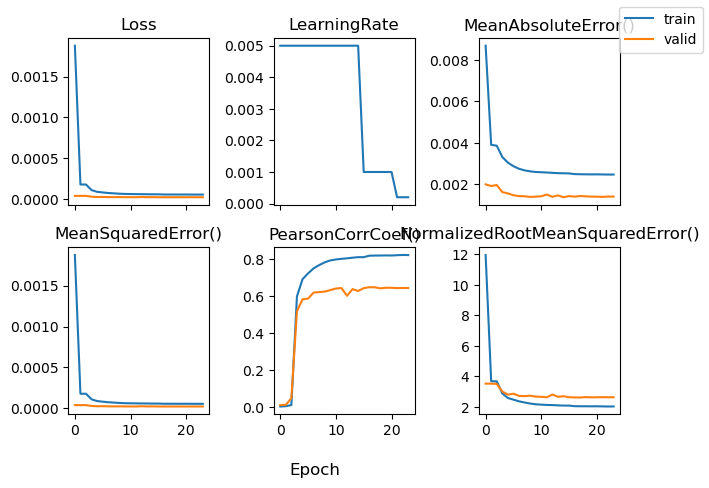

In [31]:
util.plot.plot_all_scalars_in_run(f"logs/{model_name}/history")

Calculate performance on test set

In [32]:
from tqdm import tqdm
import pandas as pd

test_metrics = util.training.get_regr_metrics()

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader, leave=False):
        y_hat = m(X)
        mask = ~torch.isnan(y)
        
        for metric in test_metrics:
            metric(y_hat[mask].view(-1), y[mask].view(-1))

for metric in test_metrics:
    print(f"{str(metric)}: {metric.compute():.3f}")

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
                                                   

NormalizedRootMeanSquaredError(): 1.921
PearsonCorrCoef(): 0.812
MeanAbsoluteError(): 0.001
MeanSquaredError(): 0.000


In [33]:
train_metrics = util.training.get_final_metrics(f"logs/{model_name}/history")

In [34]:
train_metrics

{'NormalizedRootMeanSquaredError()/train': 2.020172595977783,
 'PearsonCorrCoef()/train': 0.8220952153205872,
 'MeanAbsoluteError()/train': 0.002467316808179021,
 'MeanSquaredError()/train': 5.3541189117822796e-05,
 'NormalizedRootMeanSquaredError()/valid': 2.624300003051758,
 'PearsonCorrCoef()/valid': 0.6435993909835815,
 'MeanAbsoluteError()/valid': 0.0014025664422661066,
 'MeanSquaredError()/valid': 2.0917590518365614e-05,
 'Loss/train': 5.354733002604917e-05,
 'Loss/valid': 2.092342037940398e-05,
 'LearningRate': 0.00019999999494757503}

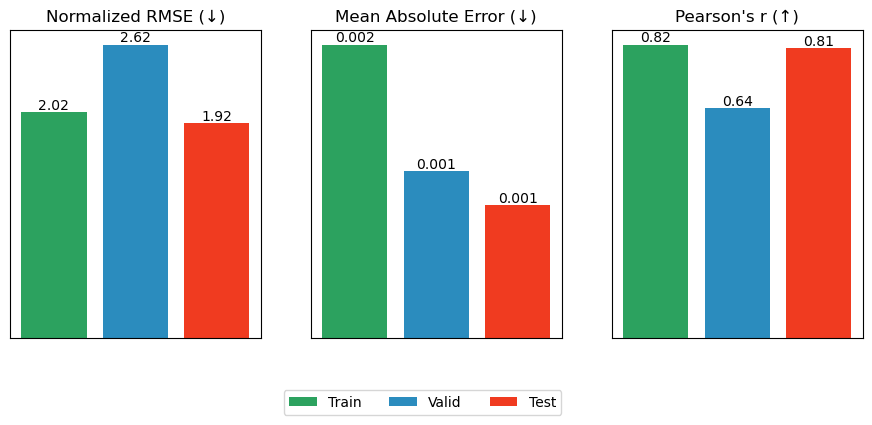

In [35]:
from matplotlib.patches import Rectangle

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 4))

nrmse = "NormalizedRootMeanSquaredError()"
mae = "MeanAbsoluteError()"
rho = "PearsonCorrCoef()"

label = ["Train", "Valid", "Test"]
color = ["#2ca25f", "#2b8cbe", "#f03b20"]

nrmse_values = [
    train_metrics[f"{nrmse}/train"],
    train_metrics[f"{nrmse}/valid"], 
    test_metrics[0].compute().cpu(), 
]
r2_values = [
    train_metrics[f"{rho}/train"], 
    train_metrics[f"{rho}/valid"], 
    test_metrics[1].compute().cpu(), 
]
mae_values = [
    train_metrics[f"{mae}/train"], 
    train_metrics[f"{mae}/valid"], 
    test_metrics[2].compute().cpu(), 
]
x = [0, 1, 2]

ax1.set_title("Normalized RMSE (↓)")
b = ax1.bar(x, nrmse_values, label=label, color=color)
ax1.bar_label(b, fmt="%.2f")
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax3.set_title("Pearson's r (↑)")
b = ax3.bar(x, r2_values, label=label, color=color)
ax3.bar_label(b, fmt="%.2f")
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
# ax2.legend()

ax2.set_title("Mean Absolute Error (↓)")
b = ax2.bar(x, mae_values, label=label, color=color)
ax2.bar_label(b, fmt="%.3f")
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
# ax2.legend()

handles, labels = ax1.get_legend_handles_labels()

plt.legend(handles, labels, ncol=3, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),
           bbox_transform = plt.gcf().transFigure)
# fig.tight_layout()

Prediction map

In [36]:
ds_infer = ds.sel(time=np.concatenate([valid_years, test_years]))
wds_infer = util.datasets.WindowXarrayDataset(
    ds_infer, window, 
    mask=ds_infer.sel(band="mortality"), 
    na_thresh=0.5,
    downsample_step=10
)
print(len(wds_infer))

63140


In [37]:
ch_means = m.convlstm.bn.running_mean.unsqueeze(-1).unsqueeze(-1)

def inference_collator(patch):
    X = torch.tensor(
            np.squeeze(patch.values[:-1, input_inds, :, :]),
            dtype=dtype,
            device=device
        ).unsqueeze(0)

    # Replace nan cells with the channel mean
    X = torch.nan_to_num(X)
    X += ch_means * torch.isnan(X)
    return X

In [38]:
out_arr = np.zeros(ds_infer.isel(band=0).shape)
out_n   = np.zeros(out_arr.shape)

m.eval()
with torch.no_grad():
    for i in tqdm(range(len(wds_infer))):
        input_tensor = inference_collator(wds_infer[i])
        t = wds_infer.valid_indices["time"][i]
        y = wds_infer.valid_indices["y"][i]
        x = wds_infer.valid_indices["x"][i]
    
        output_tensor = m(input_tensor).detach().cpu().numpy()
    
        out_arr[t, y-window_y_size+1:y+1, x-window_x_size+1:x+1] += np.log10(output_tensor[0, ...])
        out_n[t, y-window_y_size+1:y+1, x-window_x_size+1:x+1] += 1

100%|██████████| 63140/63140 [02:54<00:00, 361.51it/s]


In [39]:
out_avg = out_arr / out_n
out_arr[out_n == 0] = np.nan
out_pct = 10 ** out_avg

out_da = xr.DataArray(
    data=out_pct,
    dims=["time", "y", "x"],
    coords=dict(
        time=ds_infer.time,
        y=ds_infer.y,
        x=ds_infer.x
    )
)

/tmp/ipykernel_109/2143291068.py:1: RuntimeWarning: invalid value encountered in divide
  out_avg = out_arr / out_n


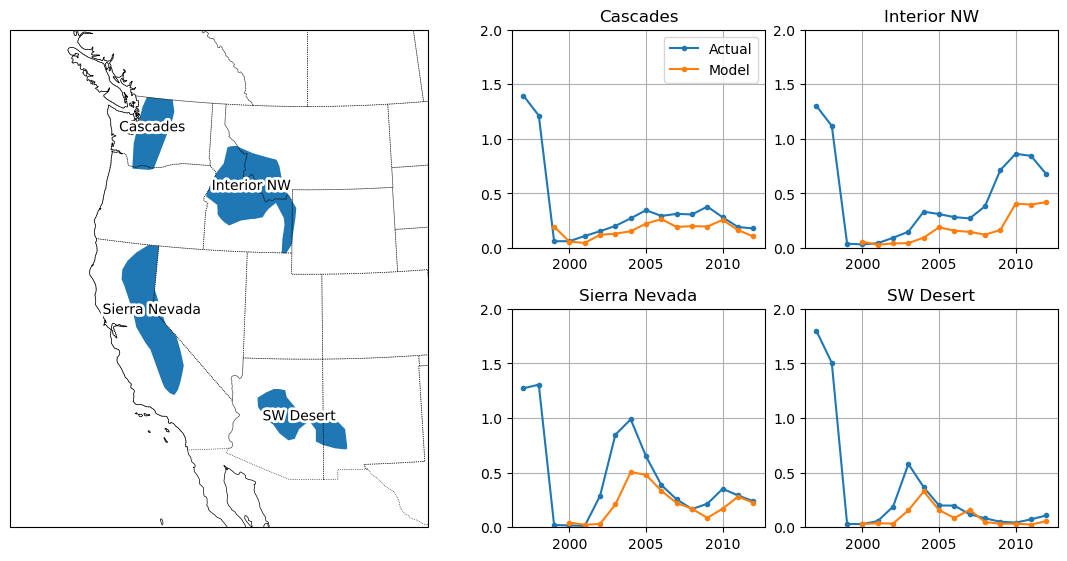

In [42]:
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe
import geopandas as gpd
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import shapely
from shapely.geometry import box

regions = gpd.read_file("data_in/regions_simple2.geojson")

fig = plt.Figure(layout="constrained", figsize=(11, 5.5))
gs = GridSpec(2, 3, figure=fig, width_ratios=[2, 1, 1])

projection = ccrs.AlbersEqualArea(central_latitude=42, central_longitude=-110)
map_ax = fig.add_subplot(gs[:, 0], projection=projection)

# Make the map
map_ax.coastlines(linewidth=0.5)

# Expand the bounding box a little so that we don't crop too much
mycrs = ccrs.epsg("3857")
bbox = box(*regions.total_bounds)
bbox = bbox.buffer(5e5) # meters

minx, miny, maxx, maxy = shapely.bounds(bbox)

# Add region geometries
for i in range(regions.shape[0]):
    geom = regions.geometry[i]
    map_ax.add_geometries(geom, crs=mycrs)
    map_ax.text(
        geom.centroid.x, geom.centroid.y, regions.name[i], 
        transform=mycrs,
        horizontalalignment="center",
        path_effects=[pe.withStroke(linewidth=4, foreground="white")]
    )

map_ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=0.5)
map_ax.set_extent((minx, maxx, miny, maxy), crs=mycrs)

axes = []

for i, (row, col) in enumerate(zip((1, 0, 1, 0), (2, 1, 1, 2))):
    ax = fig.add_subplot(gs[row, col])
    axes.append(ax)
    geom = regions.geometry[i]
    # Mean of geometric mean - no transformation necessary imo
    model = out_da.rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values * 100
    # Maybe do a geometric mean here?
    data  = ds_infer.sel(band="mort_ewma").rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values

    ax.plot(ds_infer.time, data, label="Actual", marker=".")
    ax.plot(ds_infer.time, model, label="Model", marker=".")
    ax.set_ylim(0, 2)
    ax.set_title(regions.name[i])
    ax.grid()

axes[1].legend()

fig